# Intro / motivation

This kernel is basically an refactor of [my-first-kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699) by [chauhuynh](https://www.kaggle.com/chauhuynh).  
I tried to made the code more understandable, removed some redundancy and add some (hopefully somehow useful) comments along the code. The main difference imo is that I could not use all of the features, specifically these two:
    1. new_hist_purchase_date_max
    2. new_hist_purchase_date_min

Reason is because at some point some `NaT` showed up and I wasn't able to figure it out why. Therefore I just did not used them.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import gc
from pathlib import Path
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('../'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# copy-paste
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [2]:
%%time
PATH = Path('../input/elo-merchant-category-recommendation')
df_train = pd.read_csv(PATH/'train.csv', parse_dates=['first_active_month']);
df_test = pd.read_csv(PATH/'test.csv', parse_dates=['first_active_month']);

CPU times: user 392 ms, sys: 119 ms, total: 511 ms
Wall time: 535 ms


In [3]:
%%time
df_hist_trans = pd.read_csv(PATH/'historical_transactions.csv', parse_dates=['purchase_date']);
df_new_merch_trans = pd.read_csv(PATH/'new_merchant_transactions.csv', parse_dates=['purchase_date']);

CPU times: user 1min 20s, sys: 14.4 s, total: 1min 34s
Wall time: 1min 34s


In [4]:
# https://www.kaggle.com/fabiendaniel/elo-world
def reduce_mem_usage(df, verbose=True):
    prefixes = ['int', 'float']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = str(df[col].dtype)
        if not col_type.startswith('int') and not col_type.startswith('float'):
            continue
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type.startswith('int'):
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)  
        elif col_type.startswith('float'):
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)    
    if verbose:
        end_mem = df.memory_usage().sum() / 1024**2
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/
# Same logic, but clearer (I hope so)
def fillna_mode(df, cols, pipeline=False):
    for c in cols:
        df[c].fillna(df[c].mode()[0], inplace=True)
    return df if pipeline else None


def get_nan_col_names(df: pd.DataFrame, df_name='<not named>'):
    total = df.shape[0]
    missing_cols = []
    for c in df.columns:
        quo = (total - pd.notna(df[c]).sum())/total
        if quo != 0:
            missing_cols.append(c)
    print(df_name, 'MISSING COLS:', missing_cols)
    return missing_cols

In [5]:
reduce_mem_usage(df_train);
reduce_mem_usage(df_test);
reduce_mem_usage(df_hist_trans);
reduce_mem_usage(df_new_merch_trans);

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [6]:
# print('authorized_flag: ', df_hist_trans.authorized_flag.unique())
# print('category_1: ', df_hist_trans.category_1.unique())
# print('category_2: ', df_hist_trans.category_2.unique())

In [7]:
def add_month_diff(df, pipeline=False):
    # still not sure why is useful. I mean, it is a constant changing feature.
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days) // 30
    df['month_diff'] += df['month_lag']
    return df if pipeline else None


# https://www.kaggle.com/chauhuynh/my-first-kernel-3-699
def pre_process_trans(df, date_col, date_formated=False, add_month=True):
    fillna_mode(df, cols=get_nan_col_names(df))
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0}).astype(np.int8)
    df['category_1'] = df['category_1'].map({'Y': 1, 'N': 0}).astype(np.int8)    
    df['category_2'] = df['category_2'].astype(np.int8)

    if not date_formated:
        df[date_col] = pd.to_datetime(df[date_col])
    # Separate each date component so that the model
    # can use each of them independently. This way
    # model will be feed with more potentially
    # useful information.
    df['year'] = df[date_col].dt.year
    df['weekofyear'] = df[date_col].dt.weekofyear
    df['month'] = df[date_col].dt.month
    df['dayofweek'] = df[date_col].dt.dayofweek
    df['weekend'] = (df[date_col].dt.weekday >= 5).astype(np.int8)
    df['hour'] = df[date_col].dt.hour
    if add_month:
        add_month_diff(df)


# https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]


# Refactor of https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/
def custom_group_by(df: pd.DataFrame, df_name: str, agg_by: dict):
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']
    new_columns = get_new_columns(df_name, agg_by)
    
    df_group = df.groupby('card_id').agg(agg_by)
    df_group.columns = new_columns
    df_group.reset_index(drop=False, inplace=True)
    df_group[df_name + '_purchase_date_diff'] = (
        df_group[df_name + '_purchase_date_max']
            - df_group[df_name + '_purchase_date_min']
        ).dt.days
    df_group[df_name + '_purchase_date_average'] = (
        df_group[df_name + '_purchase_date_diff']
            / df_group[df_name + '_card_id_size']
        )
    df_group[df_name + '_purchase_date_uptonow'] = (
        datetime.datetime.today()
        - df_group[df_name + '_purchase_date_max']
        ).dt.days

    return df_group

# Feature engeneering
Features are taken from:
1. [my-first-kernel][mfk]

[mfk]: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/comments

In [8]:
aggs = {}

# Count number of unique values at each column.
# Maybe this can be useful to calculate the
# probability an value is sampled
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ('nunique',)


aggs['purchase_amount'] = ('sum','max','min','mean','var')


# Maybe there are patterns regarding to loyal consumers installments
aggs['installments'] = ('sum','max','min','mean','var')

# purchase range
aggs['purchase_date'] = ('max','min')

aggs['month_lag'] = ('max','min','mean','var')
aggs['month_diff'] = ('mean',)

# How many transactions:
# - were on the weekend, and the percentage
# - has category_1 as 1 (binary feature), and the percentage
# - were authorized, and its percentage

aggs['weekend'] = ('sum', 'mean')
aggs['category_1'] = ('sum', 'mean')

# How many times and how ofter a card had a
# transaction accepted?
aggs['authorized_flag'] = ('sum', 'mean')

# How many transactions each card did?
aggs['card_id'] = ('size', )

In [9]:
# _old_train = df_train.copy()
# _odl_test = df_test.copy()
_old_train = pd.read_csv(PATH/'train.csv', parse_dates=['first_active_month']);
_odl_test = pd.read_csv(PATH/'test.csv', parse_dates=['first_active_month']);

In [10]:
%%time
gps = []
for name, df in [('hist', df_hist_trans), ('new_hist', df_new_merch_trans)]:    
    pre_process_trans(df, date_col='purchase_date')
    df_group = custom_group_by(df, name, aggs.copy())
    gps.append(df_group)
    df_train = df_train.merge(df_group, on='card_id', how='left')
    df_test = df_test.merge(df_group, on='card_id', how='left')
#     del df_group; gc.collect()


<not named> MISSING COLS: ['category_3', 'merchant_id', 'category_2']
<not named> MISSING COLS: ['category_3', 'merchant_id', 'category_2']
CPU times: user 2min 56s, sys: 2.28 s, total: 2min 59s
Wall time: 2min 59s


In [11]:
# del df_hist_trans; print(gc.collect())
# del df_new_merch_trans;print(gc.collect())

In [12]:
df_train.sample(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,hist_dayofweek_nunique,...,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_authorized_flag_sum,new_hist_authorized_flag_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
145594,2017-10-01,C_ID_56a46cdb3c,2,3,0,-0.405273,5,19,17,7,...,0.0,0.0,13.0,1.0,13.0,-0.550781,-0.554688,50.0,3.846154,788.0
88266,2017-10-01,C_ID_ee8e2b4bd8,4,1,0,-0.167603,5,16,16,7,...,0.0,0.0,14.0,1.0,14.0,-0.550293,-0.467529,55.0,3.928571,788.0
35545,2017-05-01,C_ID_1428342a1d,3,3,1,0.083313,9,14,14,7,...,0.0,0.0,4.0,1.0,4.0,-0.550293,-0.606445,37.0,9.250000,815.0
33689,2017-04-01,C_ID_74f2bbf600,2,1,0,-0.553223,5,15,16,7,...,0.0,0.0,15.0,1.0,15.0,-0.550293,-0.520508,38.0,2.533333,968.0
38750,2015-12-01,C_ID_876a2979d0,1,2,0,1.732422,7,14,16,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
prob = [
    'hist_purchase_date_max',
    'hist_purchase_date_min',
    'new_hist_purchase_date_max',
    'new_hist_purchase_date_min',
]

def post_process_df(df):
    global prob
    
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    # "Feature-spliting" just like was performed for the date columnn
    # in pre_process_trans
    df['fam_dayofweek'] = df['first_active_month'].dt.dayofweek
    df['fam_weekofyear'] = df['first_active_month'].dt.weekofyear
    df['fam_month'] = df['first_active_month'].dt.month
    df['fam_elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days

    df[prob[:2]] = df[prob[:2]].astype(np.int64) * 1e-9

    
    df['transactions_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

    for f in ['feature_1','feature_2','feature_3']:
        order_label = df_train.groupby([f])['outliers'].mean()
        df_train[f] = df_train[f].map(order_label)
        df_test[f] = df_test[f].map(order_label)
    

In [14]:
print(df_train.hist_purchase_date_max.notna().sum())
print(df_train.hist_purchase_date_min.notna().sum())
print(df_train.new_hist_purchase_date_max.notna().sum())
print(df_train.new_hist_purchase_date_min.notna().sum())

201917
201917
179986
179986


In [15]:
df_train['outliers'] = (df_train.target < -30).astype(np.int8)

In [16]:
post_process_df(df_train)
post_process_df(df_test)

In [17]:
df_test.drop(['new_hist_purchase_date_max', 'new_hist_purchase_date_min'], axis=1, inplace=True)
df_train.drop(['new_hist_purchase_date_max', 'new_hist_purchase_date_min'], axis=1, inplace=True)

In [18]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month', 'outliers', 'target']]
target = df_train['target']
del df_train['target']

In [19]:
# copy-paste
%time
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 3.66216	valid_1's rmse: 3.7308
[200]	training's rmse: 3.58365	valid_1's rmse: 3.70641
[300]	training's rmse: 3.53682	valid_1's rmse: 3.69654
[400]	training's rmse: 3.49996	valid_1's rmse: 3.69033
[500]	training's rmse: 3.47025	valid_1's rmse: 3.68698
[600]	training's rmse: 3.44382	valid_1's rmse: 3.68544
[700]	training's rmse: 3.42153	valid_1's rmse: 3.68439
[800]	training's rmse: 3.40209	valid_1's rmse: 3.68363
[900]	training's rmse: 3.38352	valid_1's rmse: 3.6834
[1000]	training's rmse: 3.3658	valid_1's rmse: 3.68261
[1100]	training's rmse: 3.34994	valid_1's rmse: 3.68264
[1200]	training's rmse: 3.33392	valid_1's rmse: 3.68206
[1300]	training's rmse: 3.31895	valid_1's rmse: 3.68221
[1400]	training's rmse: 3.30415	valid_1's rmse: 3.68206
[1500]	training's rmse: 3.29063	valid_1's rmse: 3.68184
[1600]	training's rmse: 3.27739	valid_1

3.6590694996254176

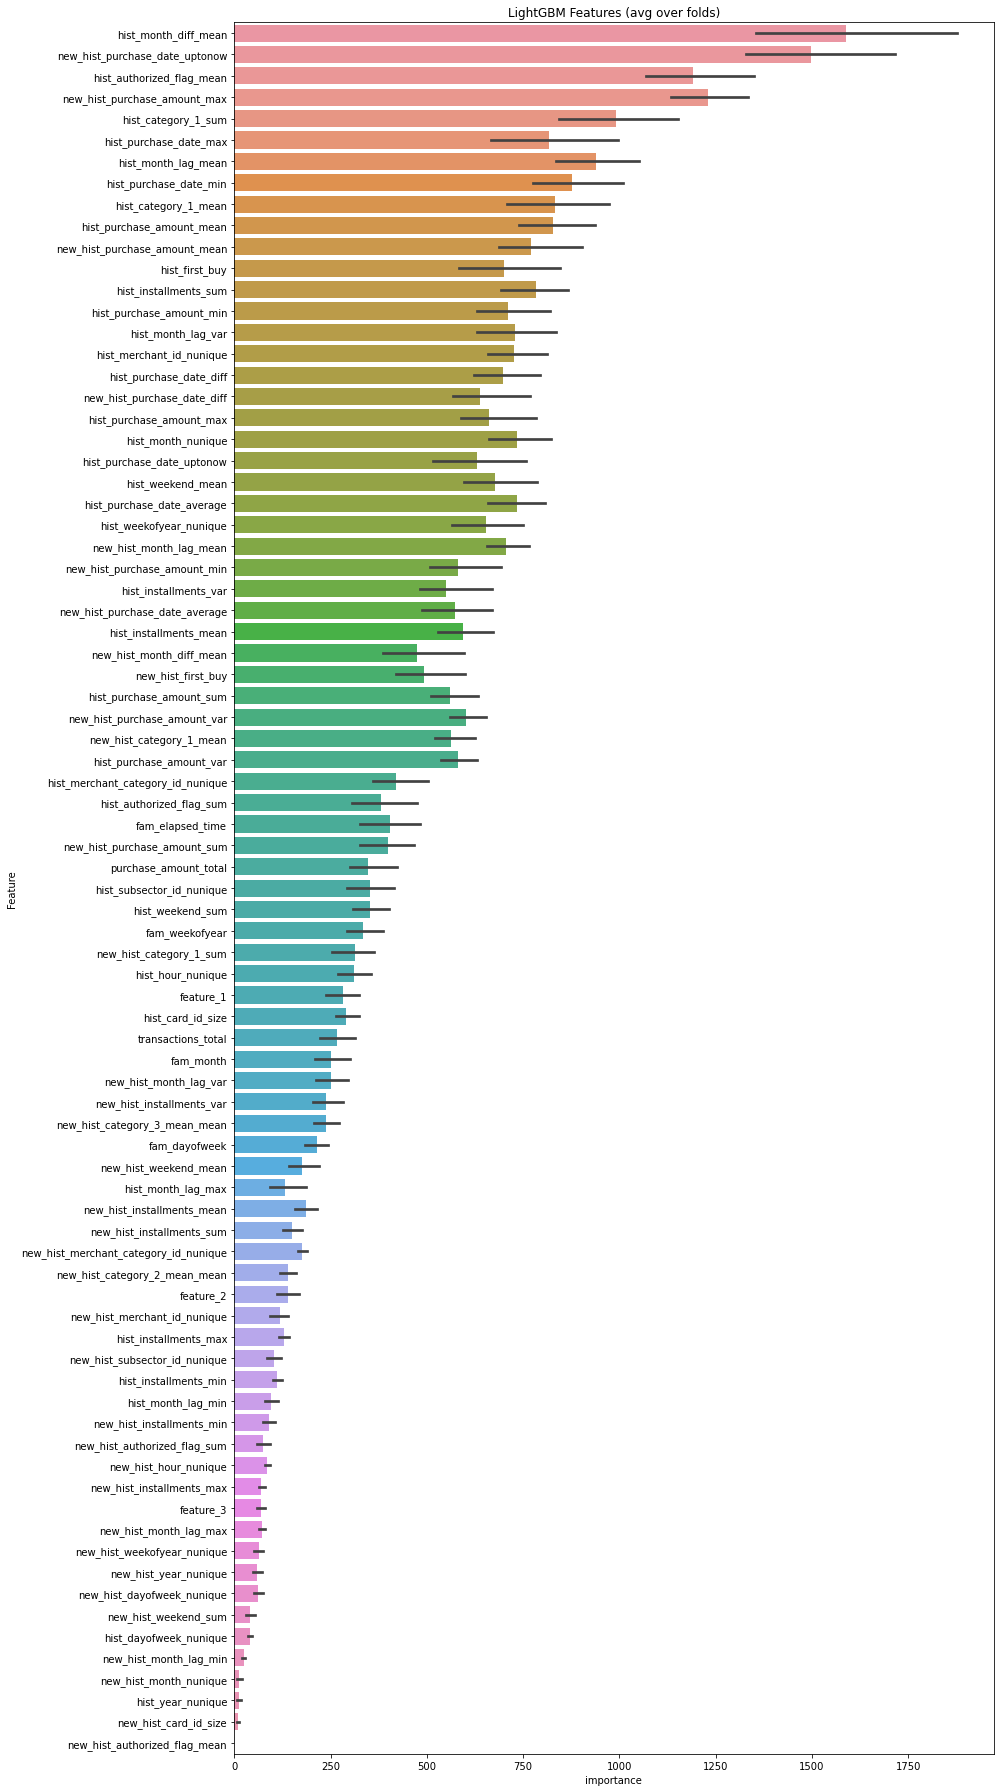

In [20]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [21]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

# Some comments

I still don't understanf what is the point of the widespread used feature `new_hist_purchase_date_uptonow`. Interestingly, when compared to the original kernel, this feature seems to have **more importance now than 2 years ago**. 

# Resources

0. [base kernel][base]
1. [Why LGBM][lgbm]
2. [LGBM x XGB][lgbm-xgb]
3. [Parameter Tuning][param-tuning]


[base]: https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/comments
[lgbm]: https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73762
[lgbm-xgb]: https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/80484
[param-tuning]: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html